In [1]:
from gdsCAD import *
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
data = np.array([[0, 1, 2, 3, 1, 1, 1, 2, 2, 2, 3, 3],
                 [0, 1, 2, 3, 1, 1, 1, 2, 2, 2, 3, 3],
                 [0, 1, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2],
                 [1, 1, 2, 3, 1, 2, 3, 1, 1, 2, 2, 2],
                 [1, 1, 2, 3, 1, 1, 2, 2, 1, 2, 1, 1],
                 [1, 1, 2, 3, 0, 1, 2, 2, 2, 2, 1, 0]])

Writing the following cells
Layer2_fwTGmNNQ: Cell ("Layer2_fwTGmNNQ", 1 elements, 0 labels)
TOP_fwTGmNKQ: Cell ("TOP_fwTGmNKQ", 1 elements, 0 labels)
Layer1_fwTGmNLQ: Cell ("Layer1_fwTGmNLQ", 1 elements, 0 labels)
GRID_fwTGmNJQ: Cell ("GRID_fwTGmNJQ", 66 elements, 0 labels)


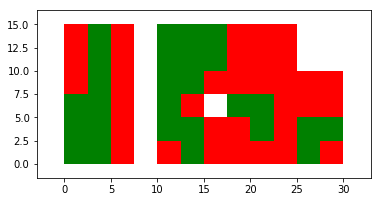

<Figure size 432x288 with 0 Axes>

In [3]:
height, width = np.shape(data)
elements = np.unique(data)
base = elements[1]
mask = elements[-1]-data
mask = mask/base
Nlayers = len(elements)/2
cellSize = 2.5

# Create the grid and dictionary for storing the unit cells
unitCells = {}
grid = core.Cell("GRID")
#amarks = templates.AlignmentMarks(('A', 'C'), (1,2))

for i in range(Nlayers):
    unitCells[i+1] = core.Cell("Layer%d" % (i+1))
    square = shapes.Rectangle((0.0, 0.0), (1.0, 1.0), layer=(int)(i+1))
    unitCells[i+1].add(square)

for i in range(height):
    for j in range(width):
        depth = mask[i, j]
        for k in range(Nlayers):
            etch = Nlayers-k
            if (depth/etch) >= 1:
                cell = core.CellReference(unitCells[etch], origin=(j, height-i-1))
                grid.add(cell)
                depth = depth % etch

scaledGrid = core.CellReference(grid, origin=(0, 0), magnification=(float)(cellSize))

top = core.Cell("TOP")
top.add(scaledGrid)

# Add the top-cell to a layout and save
layout = core.Layout("LAYOUT")
layout.add(top)
layout.save("test.gds")
layout.show()

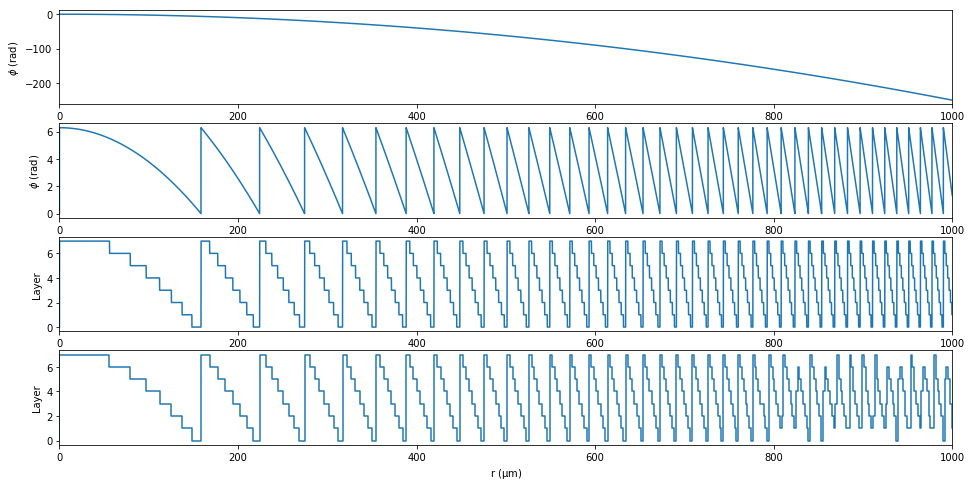

In [4]:
# Now figure out how to go from a phase profile to concentric circles
# Phase profile comes in as a 1D set of radii and phase
r = np. linspace(0, 1000, 100)
phi = -2.5e-4*r**2
phif = interp1d(r, phi, kind='cubic')
layers = 8
min_feature = 2
lim = (0, 1000)

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(r, phi)
plt.xlim(lim)
plt.ylabel(r'$\phi$ (rad)')
r_nm = np.linspace(0, 1000, 1000000, endpoint=False)
phi_nm = phif(r_nm)
phi_nm = phi_nm % (2*np.pi)
plt.subplot(412)
plt.plot(r_nm, phi_nm)
plt.xlim(lim)
plt.ylabel(r'$\phi$ (rad)')

phi_d = np.floor(phi_nm*layers/(2*np.pi))
plt.subplot(413)
plt.plot(r_nm, phi_d)
plt.xlim(lim)
plt.ylabel('Layer')

# Parse the phase to find the start and end of each ring
rings = {0 : {'r':0, 'l':0}}
j = 0
phi_cur = 0
for i in range(len(r_nm)):
    if phi_d[i] != phi_cur:
        j += 1
        phi_cur = phi_d[i]
        r_tran = np.round(r_nm[i], 3)
        rings[j] = {'r':r_tran,'l':phi_cur}
        rings[j-1]['rf'] = r_tran
# Have to set the outside of the last ring and make sure it is always large enough
rings[j]['rf'] = r[-1]+min_feature

del rings[0]
delta = np.zeros(len(rings)-1)
for i in range(1, len(rings)):
    delta[i-1] = rings[i+1]['r']-rings[i]['r']

# Find each region where the phase is changing too fast
small = delta < min_feature
region = {}
j = 0
for i in range(1, len(small)):
    # Beginning of a region
    if small[i] == True and small[i-1] == False:
        region[j] = {'start' : i+1}
    # End of a region
    if small[i] == False and small[i-1] == True:
        region[j]['end'] = i+1
        j += 1
    if i == len(small)-1 and j in region:
        region[j]['end'] = i+2

for i in range(len(region)):
    start_ind = region[i]['start']
    end_ind = region[i]['end']
    start = rings[start_ind]['r']
    end = rings[end_ind]['r']
    # Remove the old rings
    for j in range(start_ind, end_ind):
        del rings[j]
    dr = end - start
    n = int(np.floor(dr / min_feature))
    dr = dr / n
    # Add in new rings
    for j in range(start_ind, start_ind+n):
        r_start = rings[j-1]['r']
        r = np.round(r_start+dr, 3)
        rf = np.round(r+dr, 3)
        sel = np.logical_and(r_nm >= r_start, r_nm < r)
        l = np.floor(np.average(phi_nm[sel])*layers/(2*np.pi))
        rings[j] = {'r':r, 'l':l, 'rf':rf}

# Reconstruct the phase to make sure it looks right
r_plot = np.zeros(2*len(rings))
phi_plot = np.zeros(2*len(rings))
i = 0
for key, item in rings.items():
    r_plot[2*i] = item['r']
    r_plot[2*i+1] = item['r']
    phi_plot[2*i+1] = item['l']
    if i != (len(rings)-1):
        phi_plot[2*i+2] = item['l']
        i += 1
        
plt.subplot(414)
plt.plot(r_plot, phi_plot)
plt.xlim(lim)
plt.ylabel('Layer')
plt.xlabel(r'r $\mathrm{(\mu m)}$')

plt.show()

Writing the following cells
CONT_ALGN_fwSoOSgQ: Cell ("CONT_ALGN_fwSoOSgQ", 4 elements, 0 labels)
Align_fwSoQbfQ: Cell ("Align_fwSoQbfQ", 6 elements, 0 labels)
CONT_ALGN_fwSv45cQ: Cell ("CONT_ALGN_fwSv45cQ", 9 elements, 0 labels)
CONT_ALGN_fwSoOSdQ: Cell ("CONT_ALGN_fwSoOSdQ", 4 elements, 0 labels)
CONT_ALGN_fwSoQbmQ: Cell ("CONT_ALGN_fwSoQbmQ", 9 elements, 0 labels)
CONT_ALGN_fwSoOSeQ: Cell ("CONT_ALGN_fwSoOSeQ", 9 elements, 0 labels)
TOP_fwSoQbnQ: Cell ("TOP_fwSoQbnQ", 459 elements, 0 labels)
CONT_ALGN_fwSoOSfQ: Cell ("CONT_ALGN_fwSoOSfQ", 4 elements, 0 labels)


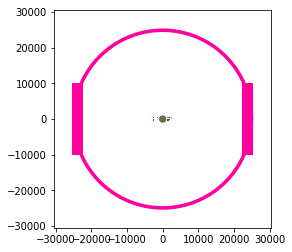

<Figure size 432x288 with 0 Axes>

In [34]:
# Now create the actual gds file
top = core.Cell("TOP")
for i in range(5):
    if layers <= 2**i:
        Nlayers = i

for key, item in rings.items():
    depth = layers-item['l']-1
    radius = item['rf']
    inner_radius = item['r']
    for k in range(Nlayers):
        etch = 2**(Nlayers-k-1)
        if (depth/etch) >= 1:
            ring = shapes.Disk((0, 0), radius, inner_radius=inner_radius, layer=etch, number_of_points=500)
            top.add(ring)
            depth = depth % etch

# Blank alignment marks
dx = 500
align = core.Cell("Align")
align.add(templates.AlignmentMarks(('A', 'C'), (4, 1)), origin=(-dx, dx))
align.add(templates.AlignmentMarks(('A', 'C'), (2, 1)), origin=(-dx, 0))
align.add(templates.AlignmentMarks('A', 1), origin=(-dx, -dx))
align.add(templates.AlignmentMarks(('A', 'C'), (4, 2)), origin=(0, dx))
align.add(templates.AlignmentMarks('A', 2), origin=(0, 0))
align.add(templates.AlignmentMarks('A', 4), origin=(dx, dx))
#top.add(templates)

# Add the top-cell to a layout and save
top.add(align, origin=(2000, 0))
top.add(align, origin=(-2000, 0))
top.add(align, origin=(2000+dx, 0), magnification=0.2)
top.add(align, origin=(dx-2000, 0), magnification=0.2)

top.add(shapes.Disk((0, 0), 25400, inner_radius=24400, layer=10, number_of_points=500))
height = 20000
width = 3200
d = 25400-width/2
top.add(shapes.Rectangle((d+width/2, height/2), (d-width/2, -height/2,), layer=10))
top.add(shapes.Rectangle((-d+width/2, height/2), (-d-width/2, -height/2,), layer=10))
layout = core.Layout("LAYOUT")
layout.add(top)
layout.save("test_ring.gds")
layout.show()